In [25]:
## PATH settings
import os
import sys
project_root = os.path.abspath(os.path.join(os.getcwd(), '../../'))
sys.path.append(project_root)
COMMON_PATH = os.path.join(project_root, 'common')
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [27]:
## Bespoke class imports
from common.database.adatabase import ADatabase
from common.processor.processor import Processor as p
from financial_common.indicator.indicator import Indicator
from financial_common.risk.benchmark import Benchmark
from financial_common.portfolio_management.kpi import KPI
from financial_common.metric.metric import Metric
from financial_common.portfolio_management.portfolio_selection import PortfolioSelection
from financial_common.risk.risk_type import RiskType
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats.mstats import winsorize

In [3]:
## Import standard packages
from datetime import timedelta, datetime
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
from time import sleep
import copy

In [4]:
market = ADatabase("market")
fred = ADatabase("fred")
orivault = ADatabase("ori")

In [5]:
## Retrieve existing stocks 
market.connect()
index = market.retrieve("index")
market.disconnect()

In [6]:
## Defining Benchmark
market.connect()
benchmark = market.query("prices",{"ticker":"JPM"})
market.disconnect()
benchmark = Benchmark.convert_to_benchmark(benchmark,"adjclose")

In [7]:
rolling_window = 10
market.connect()
prices = []
skips = 1
model_end = 2020
backtest_end = 2022
for ticker in tqdm(index["ticker"][::skips]): 
    try:
        price = market.query("prices", {"ticker": ticker})
        price["market_cap"] = price["adjclose"] * price["volume"]
        if price.index.size > 150:
            price = p.lower_column(price)
            price = p.utc_date(price)
            price = p.additional_date_columns(price)
            price = price[(price["year"]>=model_end) & (price["year"]<backtest_end)]
            price.sort_values("date", inplace=True)
            price["dividend"] = 0
            price["coefficient_of_variation"] = 1
            price = Metric.STANDARD_DEV.calculate(price,timeframe=rolling_window)
            price = Metric.NEXT_CLOSE.calculate(price,timeframe=rolling_window)
            price = Metric.NEXT_OPEN.calculate(price,timeframe=rolling_window)
            prices.append(price.dropna())
    except Exception as e:
        print(str(e))
        continue
market.disconnect()

  8%|██████████████████▋                                                                                                                                                                                                               | 931/11278 [00:15<02:42, 63.66it/s]

'adjclose'


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                              | 8140/11278 [02:16<00:50, 61.63it/s]

'adjclose'


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 9434/11278 [02:34<00:25, 73.51it/s]

'adjclose'


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 10318/11278 [02:49<00:15, 62.52it/s]

'adjclose'


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 10585/11278 [02:54<00:10, 67.40it/s]

'adjclose'


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11278/11278 [03:04<00:00, 61.09it/s]


In [35]:
simulation = pd.concat(prices)

In [36]:
simulation.sort_values("date",inplace=True)
simulation = simulation.rename(columns={"next_high":"next_open"})
simulation.columns

Index(['date', 'open', 'adjclose', 'high', 'low', 'volume', 'ticker',
       'market_cap', 'year', 'month', 'quarter', 'week', 'day', 'weekday',
       'dividend', 'coefficient_of_variation', 'adjclose_test', 'high_test',
       'low_test', 'volume_test', 'standard_dev', 'next_close', 'next_open'],
      dtype='object')

In [37]:
portfolios = PortfolioSelection.generate_possible_portfolios(
                                                            ranking_metrics=[
                                                                "volume_return"
                                                            ]
                                                            ,num_of_groups=[1]
                                                            ,group_percentages=[1]
                                                            ,max_prices=[10]
                                                            ,min_prices=[1]
                                                            ,max_market_caps = [5000000]
                                                            ,min_market_caps = [1000000]
                                                            ,stoplosses=[0.05]
                                                            ,rolling_windows=[rolling_window]
                                                            ,leverages=[1]
                                                            )
filtered_portfolios = []
for portfolio in portfolios:
    if portfolio.timeframe.value == "day" and "blacklist" in portfolio.selection_type.label \
        and portfolio.allocation_type.label == "equal" \
        and portfolio.grouping_type.value == "standard_dev" \
        and portfolio.position_type.label == "long" and portfolio.max_price > portfolio.min_price:
        filtered_portfolios.append(portfolio)

In [41]:
analysises = []
for portfolio in tqdm(filtered_portfolios):
    try:
        indicator_class = Indicator.indicator_type_factory(portfolio.ranking_metric)
        if portfolio.ranking_metric not in simulation.columns:
            simulation = simulation.sort_values("date")
            simulation = simulation.groupby("ticker").apply(lambda x: indicator_class.calculate(x, rolling_window)).reset_index(drop=True)
        trades = portfolio.trades(simulation.copy())
        trades = p.additional_date_columns(trades)
        trades.sort_values("date")
        performance = portfolio.portfolio(trades.copy(),benchmark.copy())
        metrics = KPI.performance(trades,performance)
        results = {**portfolio.to_dict(),**metrics.copy()}
        results["portfolio"] = portfolio
        analysises.append(results)
    except Exception as e:
        print(str(e))
        continue

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:07<00:00,  3.52s/it]


In [42]:
a = pd.DataFrame(analysises)

In [43]:
metric = "raw_pnl"
dropped_columns = ["date","risk_type","max_market_cap","min_market_cap","timeframe","selection_percentage","rolling_window","portfolio"]
filtered_a = a.drop(dropped_columns,axis=1).sort_values(metric,ascending=False)
top = a.sort_values(metric,ascending=False).head(20).to_dict("records")[0]
filtered_a.head(20)

,ranking_metric,position_type,grouping_type,selection_type,allocation_type,stoploss,num_of_groups,max_price,min_price,leverage,pnl,raw_pnl,downside,coefficient_of_variation,portfolio_std,sharpe_ratio,tracking_error,information_ratio
0,volume_return,long,STANDARD_DEV,top_blacklist,equal,0.05,1,10,1,1,3.910645,145.597161,0.949843,4.804141,0.814016,2.768321,0.596597,3.777185
1,volume_return,long,STANDARD_DEV,bottom_blacklist,equal,0.05,1,10,1,1,2.745142,7.122254,0.970199,3.726477,0.736659,1.476875,0.464373,2.342845


In [44]:
pm = top["portfolio"]
trades = pm.trades(simulation.copy())
trades = p.additional_date_columns(trades).sort_values("date")
portfolio = pm.portfolio(trades,benchmark)

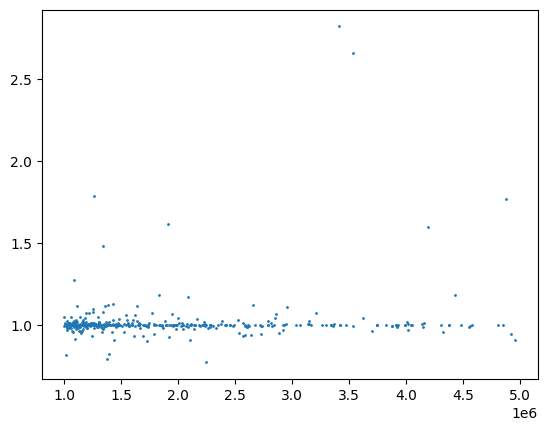

In [45]:
plt.scatter(trades["market_cap"],trades["unweighted_return"],s=1)
plt.show()

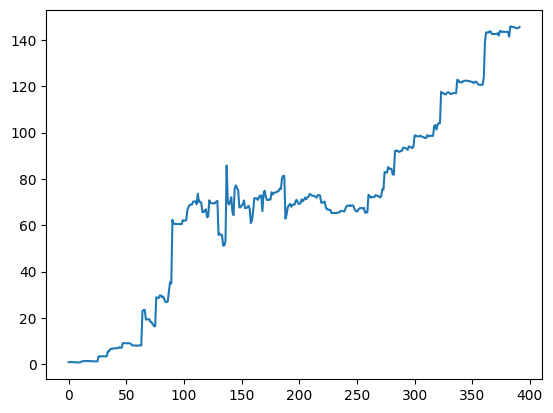

In [46]:
plt.plot(portfolio["raw_pnl"])
plt.show()

In [47]:
trades["unweighted_return"].mean()

np.float64(1.0192121778732988)

In [ ]:
orivault.connect()
orivault.drop("results")
orivault.store("results",pd.DataFrame([top]).drop("portfolio",axis=1))
orivault.disconnect()